In [24]:
import numpy as np
import os
import sys
import tensorflow as tf
import collections
import re

from PIL import Image
import pandas as pd
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

sys.path.append("../src/models/research/object_detection")
sys.path.append("../src/models")
sys.path.append("../src/models/research")

from utils import label_map_util
from utils import visualization_utils as vis_util

%matplotlib inline

In [10]:
def detect(dir, min_score_thresh=0.05, draw_box=True):
    images = get_images(dir)
    df = run_detection(images,
                       min_score_thresh=min_score_thresh,
                       draw_box=draw_box)
    return df


def get_images(dir):
    images = list()
    files = next(os.walk(dir))[2]
    file_convention = "LOC_(\\d+)_h(\\d+).jpg"
    for f in files:
        result = re.search(file_convention, f)
        if result:
            lid = result.group(1)
            heading = result.group(2)
            path = os.path.join(dir, 'LOC_{}_h{}.jpg'.format(lid, heading))
            images.append({
                'lid': lid,
                'heading': heading,
                'path': os.path.abspath(path)})
    return images


def run_detection(images, min_score_thresh=0.05, draw_box=True):
    # Path to frozen detection graph. This is the actual model that is used for
    # the object detection.
    MODEL_NAME = 'faster_rcnn_resnet101_coco_11_06_2017'
    PATH_TO_CKPT = os.path.join("../models",
                                MODEL_NAME + '/frozen_inference_graph.pb')
    # List of the strings that is used to add correct label for each box.
    PATH_TO_LABELS = os.path.join('../src/models/research/object_detection/data',
                                  'mscoco_label_map.pbtxt')

    NUM_CLASSES = 90

    # Load a (frozen) Tensorflow model into memory
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')

    # loading label map
    label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
    categories = label_map_util.convert_label_map_to_categories(
        label_map,
        max_num_classes=NUM_CLASSES,
        use_display_name=True)
    category_index = label_map_util.create_category_index(categories)

    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            for image_dict in images:
                image = Image.open(image_dict['path'])
                image_np = load_image_into_numpy_array(image)
                image_np_expanded = np.expand_dims(image_np, axis=0)
                image_tensor = detection_graph.get_tensor_by_name(
                    'image_tensor:0')
                boxes = detection_graph.get_tensor_by_name(
                    'detection_boxes:0')
                scores = detection_graph.get_tensor_by_name(
                    'detection_scores:0')
                classes = detection_graph.get_tensor_by_name(
                    'detection_classes:0')
                num_detections = detection_graph.get_tensor_by_name(
                    'num_detections:0')

                (boxes, scores, classes, num_detections) = sess.run(
                    [boxes, scores, classes, num_detections],
                    feed_dict={image_tensor: image_np_expanded})

                ep = expected_person(
                    image_np,
                    np.squeeze(boxes),
                    np.squeeze(classes).astype(np.int32),
                    np.squeeze(scores),
                    category_index,
                    image_dict['path'],
                    min_score_thresh=min_score_thresh,
                    draw_box=draw_box
                )

                image_dict['ped_exp'] = ep

    df = pd.DataFrame(images)
    return df


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


def expected_person(image,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    filename,
                    max_boxes_to_draw=200,
                    min_score_thresh=.05,
                    draw_box=True):

    box_to_display_str_map = collections.defaultdict(list)
    box_to_color_map = collections.defaultdict(str)

    if not max_boxes_to_draw:
        max_boxes_to_draw = boxes.shape[0]

    expected_person = 0
    for i in range(min(max_boxes_to_draw, boxes.shape[0])):
        if scores is None or scores[i] > min_score_thresh:
            class_name = category_index[classes[i]]['name']
            if class_name == 'person':
                expected_person += scores[i]
                display_str = '{}: {}%'.format(
                    class_name,
                    int(100*scores[i]))
                box = tuple(boxes[i].tolist())
                box_to_display_str_map[box].append(display_str)
                box_to_color_map[box] = 'DarkOrange'

    # Draw all boxes onto image.
    if draw_box:
        for box, display_str in box_to_display_str_map.items():
            ymin, xmin, ymax, xmax = box
            color = 'DarkOrange'
            vis_util.draw_bounding_box_on_image_array(
                image,
                ymin,
                xmin,
                ymax,
                xmax,
                color=color,
                thickness=4,
                display_str_list=display_str,
                use_normalized_coordinates=True)

        im = Image.fromarray(image)
        
        image_path, image_name = os.path.split(filename)
        image_name = image_name.replace(".jpg", "_anno.jpeg")
        im.save(os.path.join("../data/processed", image_name))

    return expected_person

In [11]:
%%time
image_dir = '../data/raw/streetview'
result = detect(image_dir, min_score_thresh=0.2, draw_box=True)

CPU times: user 17min 10s, sys: 24.9 s, total: 17min 35s
Wall time: 5min 19s


In [13]:
result.head()

,heading,lid,path,ped_exp
0,0,5239,/Users/yonghah/repo/nyc_ped_count_cnn/data/raw...,0.308350
1,108,5239,/Users/yonghah/repo/nyc_ped_count_cnn/data/raw...,0.000000
2,144,5239,/Users/yonghah/repo/nyc_ped_count_cnn/data/raw...,0.000000
3,180,5239,/Users/yonghah/repo/nyc_ped_count_cnn/data/raw...,0.000000
4,216,5239,/Users/yonghah/repo/nyc_ped_count_cnn/data/raw...,0.243033


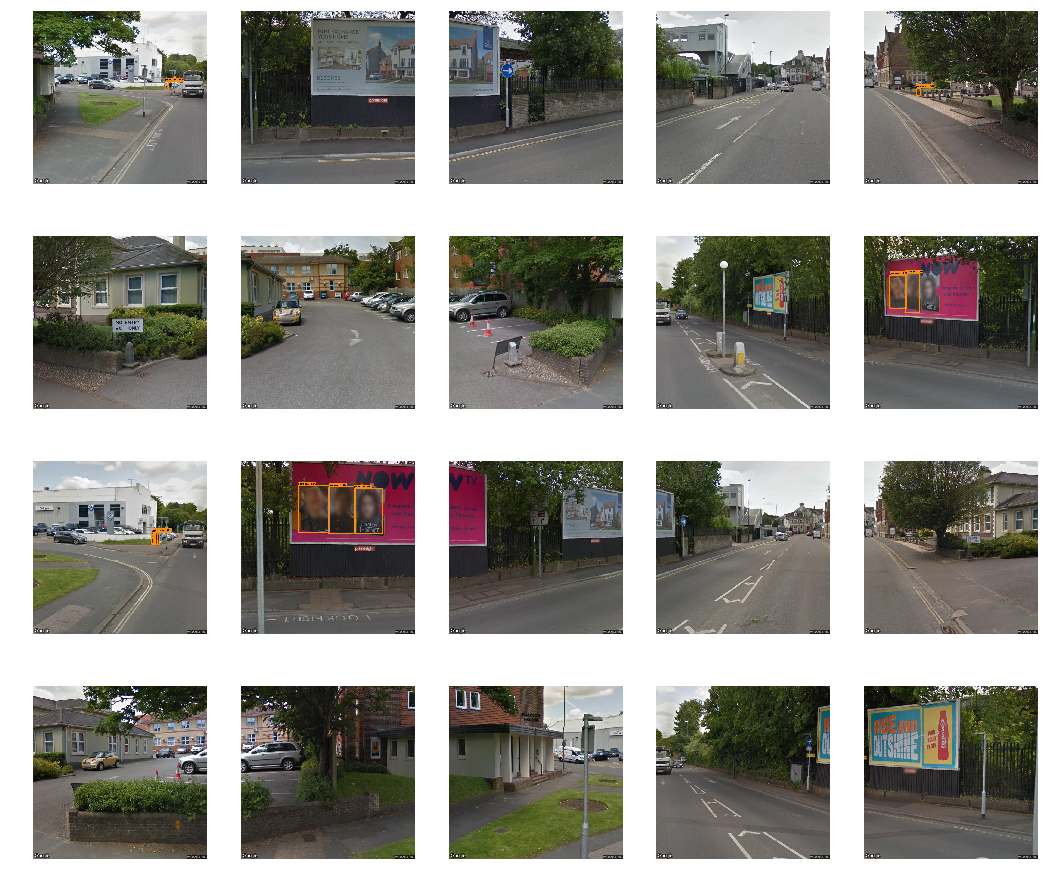

In [28]:
# look at images
images = []
outputs = "../data/processed"
pic_per_obs = 10
for img_path in sorted(glob.glob(outputs +'/*anno.jpeg'), key=os.path.getmtime):
    images.append(mpimg.imread(img_path))
    
plt.figure(figsize=(18,20))
columns = pic_per_obs /2
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.axis('off')
    plt.imshow(image)

In [29]:
# group by lid
result.groupby('lid').agg('sum')

,ped_exp
lid,
5239,1.021575
5240,3.575050
